In [7]:
! wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
! tar -xvzf ml-20m-compact.tar.gz
! pip install caserecommender

--2022-05-06 18:21:13--  https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz [following]
--2022-05-06 18:21:14--  https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65019041 (62M) [application/octet-stream]
Saving to: ‘ml-20m-compact.tar.gz.1’

ml-20m-compact.tar. 100%[===================>]  62.01M   218MB/s    in 0.3s    

2022-05-06 18:21:14 (218 MB/s) - ‘ml-20m-compact.tar.gz.1’ saved [65019041/6501

In [8]:
import pandas as pd
import numpy as np

In [9]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.head()

,movieId,title,genres
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary|IMAX
3,161,Crimson Tide (1995),Drama|Thriller|War
4,193,Showgirls (1995),Drama


In [10]:
movies_genres = movies.drop('genres', axis=1).join(movies.genres.str.split('|', expand=True)
             .stack().reset_index(drop=True, level=1).rename('genre'))
movies_genres.head()

,movieId,title,genre
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary
2,37,Across the Sea of Time (1995),IMAX


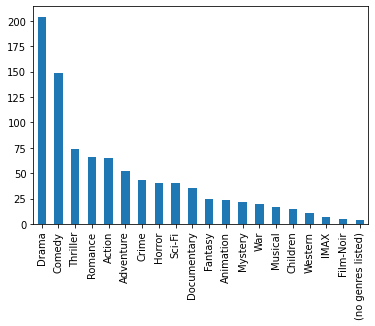

In [11]:
movies_genres.genre.value_counts().plot(kind='bar')

# Ler e preparar os dados

In [12]:
from sklearn.model_selection import train_test_split

ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

map_title = {}
for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [13]:
movies_genres['movieId'] = movies_genres['movieId'].map(map_items)
movies_genres.dropna(inplace=True)
movies_genres['movieId'] = movies_genres.movieId.astype(int)
movies_genres.head()

,movieId,title,genre
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,61,Dangerous Minds (1995),Drama
2,125,Across the Sea of Time (1995),Documentary
2,125,Across the Sea of Time (1995),IMAX


In [14]:
movies_genres[['movieId', 'genre']].to_csv('items_genres.dat', index=False, sep='\t', header=False)

### Case Recommender


In [15]:
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN

In [16]:
ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_genres.dat', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

training_time:: 6.144237 sec
>> metadata:: 417 items and 20 metadata (890 interactions) | sparsity:: 89.33%
prediction_time:: 1.205035 sec
Eval:: MAE: 0.73626 RMSE: 0.968056 


# Explorando as tags

In [17]:
movies_tags = pd.read_csv('./dataset/tags_sample.csv')
movies_tags.head()

,userId,movieId,tag,timestamp_y
0,279,916,Gregory Peck,1329962459
1,279,916,need to own,1329962471
2,279,916,romantic comedy,1329962476
3,279,916,Rome,1329962490
4,279,916,royalty,1329962474


In [18]:
movies_tags['movieId'] = movies_tags['movieId'].map(map_items)
movies_tags.dropna(inplace=True)
movies_tags['movieId'] = movies_tags.movieId.astype(int)
movies_tags.head()

,userId,movieId,tag,timestamp_y
0,279,34,Gregory Peck,1329962459
1,279,34,need to own,1329962471
2,279,34,romantic comedy,1329962476
3,279,34,Rome,1329962490
4,279,34,royalty,1329962474


In [19]:
movies_tags[['movieId', 'tag']].to_csv('items_tags.dat', index=False, sep='\t', header=False)

In [20]:
ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_tags.dat', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

training_time:: 6.065833 sec
>> metadata:: 231 items and 1979 metadata (6274 interactions) | sparsity:: 98.63%
prediction_time:: 1.832402 sec
Eval:: MAE: 0.74299 RMSE: 0.982621 


In [21]:
genome_tags = pd.read_csv('./dataset/genome-tags.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [22]:
movies_genome_tags = pd.read_csv('./dataset/genome-scores.csv')
movies_genome_tags = movies_genome_tags[movies_genome_tags['movieId'].isin(list(movies['movieId']))]
movies_genome_tags.head()

,movieId,tagId,relevance
32712,30,1,0.02775
32713,30,2,0.03425
32714,30,3,0.12200
32715,30,4,0.24750
32716,30,5,0.77875


In [23]:
movies_genome_tags['movieId'] = movies_genome_tags['movieId'].map(map_items)
movies_genome_tags.dropna(inplace=True)
movies_genome_tags['movieId'] = movies_genome_tags.movieId.astype(int)
movies_genome_tags.head()

,movieId,tagId,relevance
32712,49,1,0.02775
32713,49,2,0.03425
32714,49,3,0.12200
32715,49,4,0.24750
32716,49,5,0.77875


In [24]:
movies_genome_tags[['movieId', 'tagId', 'relevance']].to_csv('items_genome_tags.dat', index=False, sep='\t', header=False)

In [25]:
ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_genome_tags.dat', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 403 items (152496 interactions) | sparsity:: 96.59%
test data:: 10503 users and 340 items (38125 interactions) | sparsity:: 98.93%

training_time:: 6.259332 sec
>> metadata:: 200 items and 1128 metadata (225600 interactions) | sparsity:: 0.00%
prediction_time:: 1.653486 sec
Eval:: MAE: 0.692721 RMSE: 0.918445 
